In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

Priorities:
- historical conversion rate of trial members: 

In [3]:
os.getcwd()

'C:\\Users\\200669681\\OneDrive - NBCUniversal\\My Documents\\ghfc\\membershipReportsCIVI'

In [4]:
#will contain membership type history, however, if the plan had been cancelled, it won't show the start date of the membership
encompassing = pd.read_csv('./membershipReportingLogic SampleReports/membershipAllEncompassingReport.csv')

In [3]:
contactActivityDetails = pd.read_csv('./activityDetailsReport_contactReport.csv')

In [5]:
activityReport = pd.read_csv('./membershipReportingLogic SampleReports/select_activity_report.csv')

In [47]:
#top 15
contactActivityDetails[['Subject']].value_counts(dropna = False)[0:15]
#contactActivityDetails['Subject'].unique()

Subject                                          
Status changed from New to Expired                   705
Status changed from New to Active                    515
Status changed from Active to Cancelled              121
Status changed from Active to General Leave          120
Status changed from Active to Expired                 91
Status changed from Active to Deactivated             62
Status changed from Re-activated to Active            44
Status changed from Expired to Active                 42
Status changed from New to Deactivated                38
Status changed from Pending to New                    37
Type changed from Zucchini Plan to Lettuce Plan       29
Status changed from General Leave to Re-activated     26
Status changed from New to Cancelled                  18
Status changed from Parental Leave to Active          16
Status changed from Deactivated to Active             15
dtype: int64

In [4]:
member_status = encompassing[['Membership Type','Status']].value_counts()[encompassing[['Membership Type','Status']].value_counts()>10]

In [20]:
type(member_status)

pandas.core.series.Series

In [5]:
df = member_status.reset_index()

In [6]:
df2 = df.rename({'Membership Type':'membership_type','Status':'status',0:'count'}, axis = 1)

In [40]:
df2.sort_values('membership_type')

,membership_type,status,count
11,Apple Plan,Deactivated,13
13,Apple Plan,Cancelled,12
7,Carrot Plan,Current,28
9,Carrot Plan,Cancelled,22
2,Lettuce Plan,Current,112
6,Lettuce Plan,Cancelled,59
8,Lettuce Plan,Deactivated,23
10,Lettuce Plan,New,22
0,Trial Membership,Expired,1548
5,Trial Membership,New,71


In [7]:
df_wide = df2.pivot_table( index='membership_type', columns='status', values='count')

Text(0.5, 1.0, 'Heatmap: Membership Type - Status')

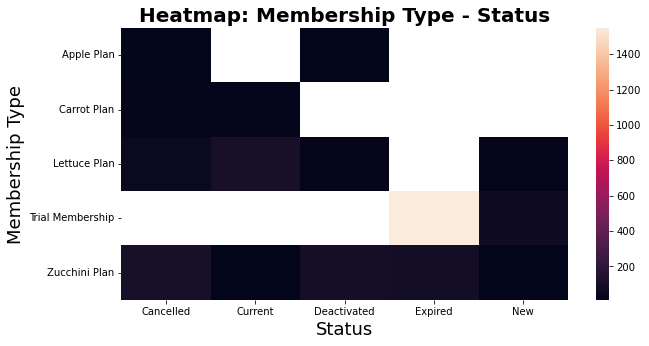

In [12]:
#plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(1, 1, figsize = (10,5))
ax = sns.heatmap(df_wide)
ax.set_ylabel('Membership Type',fontdict= { 'fontsize': 18})
ax.set_xlabel('Status',fontdict= { 'fontsize': 18})
ax.set_title('Heatmap: Membership Type - Status', fontdict = {'fontsize':20, 'fontweight':'bold'})

In [5]:
#remove New to Active subjects as those are irrelevant according to Travis
contactActivityDetails_sansNtA=contactActivityDetails.loc[~contactActivityDetails['Subject'].str.contains('New to Active'),]

In [7]:
#merge encompassing to contactActivityDetails on email of the member; encompassing:contactActivityDetails = 1:many
merged_df = pd.merge(encompassing, contactActivityDetails_sansNtA, how = 'left', left_on = 'Email', right_on = 'Target Email')
merged_df.sort_values(by = ['Email','Activity Date'],na_position = 'last', inplace = True)

In [8]:
#SECOND ITERATION OF merged_df... this one w/o removal of any of the Subject types as there is suspected data loss
merged_df2 = pd.merge(encompassing, contactActivityDetails, how = 'left', left_on = 'Email', right_on = 'Target Email')
merged_df2.sort_values(by = ['Email','Activity Date'],na_position = 'last', inplace = True)

In [12]:
merged_df.shape

(2572, 28)

In [9]:
contactActivityDetails.shape

(2004, 12)

In [8]:
merged_df['Membership Type'].unique()

array(['Trial Membership', 'Zucchini Plan', 'Lettuce Plan', 'Carrot Plan',
       'Apple Plan', 'Avocado Plan'], dtype=object)

In [9]:
merged_df['membership_hierarchy'] = merged_df['Membership Type'].replace(['Trial Membership', 'Zucchini Plan', 'Lettuce Plan', 'Carrot Plan',
       'Apple Plan', 'Avocado Plan'],[0,1,2,2,2,2])

In [10]:
merged_df2['membership_hierarchy'] = merged_df2['Membership Type'].replace(['Trial Membership', 'Zucchini Plan', 'Lettuce Plan', 'Carrot Plan',
       'Apple Plan', 'Avocado Plan'],[0,1,2,2,2,2])

Trying to tell a story of the user journey by looking at events, dates, conversions and status changes

In [14]:
merged_df.to_csv('./contacts_encompassing_merged_sansNtA.csv',index = False)

In [9]:
#analyze the keys (group names, in this case email address) to determine if there was an upgrade of some kind
grouped_hier = merged_df.groupby(['Email'])

In [10]:
groupby_ser = pd.Series(grouped_hier['membership_hierarchy'])

In [11]:
#store email addresses and hierarchy value in a list... the hierarchy was assigned at the "replace" step above
hier_list = []
email_list = []

In [12]:
#place this into a list, the pair it to a list of emails to make a dictionary
for index, value in groupby_ser.items():
    hier_list.append(set(value[1].values))
    email_list.append(value[0])

In [13]:
#make a dictionary and a data frame of the merged lists
res = dict(zip(email_list, hier_list))

In [6]:
#determine the different journey types posted to the contacts table: first, sort by activity date, will need to account for initial membership type
#merged_df.columns

In [15]:
sorted_df = merged_df.sort_values(by=['Email','Activity Date']).reset_index(drop = True)
sorted_df2 = merged_df2.sort_values(by=['Email','Activity Date']).reset_index(drop = True)

In [16]:
sorted_df.loc[:,['Email','Activity Date','Subject','Membership Type','Start Date', 'End Date','Status']].to_csv('./sorted_df.csv', index = False)

In [51]:
sorted_df2.loc[:,['Email','Activity Date','Subject','Membership Type','Start Date', 'End Date','Status']].to_csv('./sorted_df2.csv', index = False)

Isolate 
- members on non-working trial (current)
- members on working trial (current)
- members on non-working trial that converted (historical)
- members on working trial that convereted (historical)
- members on non-working trial that did not convert (historical)
- members on workig trial that did not convert (historical)
- trailing 30-day active full member-owners 
- trailing 30-day cancelled full member-owners

Possible array of status: trial, converted member owner, expired trial, cancelled membership, active member owner. Creating a table of this kind could be a cartesian plane of 365*3*1992 = 2,181,240 (#of historical member owners). Apparently pandas can handle this

In [26]:
encompassing.drop_duplicates(subset = 'Email').shape

(1992, 16)

Survey the Activty Report; this may be the only table I need

In [10]:
activityReport.columns = [i.replace(' ','_')+'_act' for i in list(activityReport.columns)]

In [11]:
encompassing.columns = [i.replace(' ','_')+'_enc' for i in list(encompassing.columns)]

In [7]:
#activityReport['Subject'].unique()
#print(activityReport.columns)
#print(encompassing.columns)

In [8]:
#extract date portion
#print(activityReport.dtypes)
#print(encompassing.dtypes)

In [12]:
activityReport = activityReport.assign(Activity_Date_DT_act = pd.to_datetime(activityReport['Activity_Date_act'], format = '%Y-%m-%d %H:%M'))

In [13]:
encompassing = encompassing.assign(Start_Date_DT_enc = pd.to_datetime(encompassing['Start_Date_enc'], format = '%Y-%m-%d %H:%M'), Date_Received_DT_enc = pd.to_datetime(encompassing['Date_Received_enc'], format = '%Y-%m-%d %H:%M'))

ValueError: time data 1/22/2022 doesn't match format specified

In [14]:
encompassing = encompassing.assign(Start_Date_DT_enc = encompassing['Start_Date_DT_enc'].dt.date, Date_Received_DT_enc = encompassing['Start_Date_DT_enc'].dt.date)

KeyError: 'Start_Date_DT_enc'

In [15]:
activityReport = activityReport.assign(Activity_Date_DT_act = activityReport['Activity_Date_DT_act'].dt.date)

In [45]:
#first merge test
# , how = 'left', left_on = 'Email', right_on = 'Target Email'
first_merge = pd.merge(activityReport,encompassing, how = 'right', left_on = ['Target_Email','Activity_Date_DT'], right_on = ['Email','Start_Date_DT'])

In [48]:
first_merge['Source_Email'].isna().value_counts()

False    2095
True      230
Name: Source_Email, dtype: int64

In [50]:
second_merge = pd.merge(activityReport,encompassing, how = 'left', left_on = ['Target_Email','Activity_Date_DT'], right_on = ['Email','Start_Date_DT'])
second_merge['Email'].isna().value_counts()

True     5594
False    2095
Name: Email, dtype: int64

In [65]:
third_merge = pd.merge(activityReport,encompassing, how = 'left', left_on = ['Target_Email_act','Activity_Date_DT_act'], right_on = ['Email_enc','Date_Received_DT_enc'])
third_merge['Email_enc'].isna().value_counts()

True     5594
False    2095
Name: Email_enc, dtype: int64

In [77]:
third_merge.loc[:,['Target_Email_act','Activity_Type_act','Subject_act','Activity_Date_DT_act','Membership_Type_enc','Status_enc','Start_Date_DT_enc','End_Date_enc','Email_enc','Date_Received_DT_enc']].sort_values(by = ['Target_Email_act','Activity_Date_DT_act']).to_csv('./mergeMiami.csv',index = False)

third_merge is good, except: 
1) I need to turn the join into a full outer join to capture non-corresponding date records btwn the two dataframes
2) I may be missing some data from 'select_activity_report.csv'... an exemplary case is email: aatiell@gmail.com... this person signed up for a Lettuce acct but this only appears in the 'all encompassing' file. *Discovered with Travis that Target_Email_act may be the key to relating all relevant activity by user: selectively refer to email accounts in this field in order to properly merge with the "encompassing" table. A selective reference is necessary as the original foreign key was "Target_Email_act" and this is unreliable in cases of blanks/nulls

In [16]:
activityReport = activityReport.assign(email_grouping = activityReport.apply(lambda x: x['Target_Email_act'] if re.match('admin@greenehillfood.coop|it@greenehillfood.coop', x['Source_Email_act']) else x['Source_Email_act'], axis = 1))

In [18]:
activityReport.loc[activityReport['email_grouping']=='aatiell@gmail.com',:].sort_values(by = 'Activity_Date_DT_act')

,Assignee_Name_act,Target_Name_act,Source_Email_act,Target_Email_act,Activity_Type_act,Subject_act,Activity_Date_act,Activity_Status_act,Activity_Details_act,Activity_Date_DT_act,email_grouping
5575,NaN,"Agustin Tiell, Alba",aatiell@gmail.com,aatiell@gmail.com,Membership Signup,Zucchini Plan - Trial Plan Application - Statu...,2021-12-12 09:44,Completed,NaN,2021-12-12,aatiell@gmail.com
5979,NaN,"Agustin Tiell, Alba",admin@greenehillfood.coop,aatiell@gmail.com,Change Membership Status,Status changed from New to Active,2022-02-11 01:54,Completed,NaN,2022-02-11,aatiell@gmail.com
6877,NaN,"Agustin Tiell, Alba",admin@greenehillfood.coop,aatiell@gmail.com,Change Membership Status,Status changed from Active to Expired,2022-06-11 02:54,Completed,NaN,2022-06-11,aatiell@gmail.com
6953,NaN,NaN,aatiell@gmail.com,NaN,Change Membership Status,Status changed from Expired to Active,2022-06-27 10:25,Completed,NaN,2022-06-27,aatiell@gmail.com
6954,NaN,NaN,aatiell@gmail.com,NaN,Change Membership Type,Type changed from Zucchini Plan to Lettuce Plan,2022-06-27 10:25,Completed,NaN,2022-06-27,aatiell@gmail.com


In [30]:
activityReport.loc[:,['Activity_Type_act', 'Subject_act',
       'Activity_Date_act', 'Activity_Status_act', 'Activity_Details_act',
       'Activity_Date_DT_act','email_grouping']].sort_values(by = ['email_grouping','Activity_Date_DT_act']).to_csv('./activityReportsNormalized.csv', index = False)

Thinking about establishing a hierarchy to label the predominating status of ea member at a moment in time, this will involve ignoring some activities like trial expirations when a higher trial (Zucchini) was been invoked.
There are two types of relevant activities: change in membership types (including signups) and status changes: cancellations, expirations, general leave, etc

Other idea: 1) select for pertinent (or irrelevant Subject_act values). 2) Establish a lookback of the last two activity types to gauge the journey step at each row

ELABORATION
1) appears as though "Status changed from Expired to Active' and 'Status changed from New to Active' can be removed
2) pandas groupby: shift(-1) and shift(-2); I have the option of creating functions or even a class for this work

In [38]:
#take a look at the permutations of some field values
groups = activityReport.groupby('Activity_Type_act')['Subject_act'].apply(list)
df1 = groups.reset_index(name = 'listvalues')

In [40]:
df1.loc[df1['Activity_Type_act'] == 'Change Membership Status',:]

,Activity_Type_act,listvalues
0,Change Membership Status,"[Status changed from New to Expired, Status ch..."
